# Lab 01
reference: https://www.youtube.com/watch?v=-yhm3WdGFok  

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(x):
    """ Sigmoid function.
    This function accepts any shape of np.ndarray object as input and perform sigmoid operation.
    """
    return 1 / (1 + np.exp(-x))


def der_sigmoid(y):
    """ First derivative of Sigmoid function.
    The input to this function should be the value that output from sigmoid function.
    """
    return y * (1 - y)

In [3]:
class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """ Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data = np.random.uniform(0, 1, (n, 2))

        inputs = []
        labels = []

        for point in data:
            inputs.append([point[0], point[1]])

            if point[0] > point[1]:
                labels.append(0)
            else:
                labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """ Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def fetch_data(mode, n):
        """ Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == 'Linear' or mode == 'XOR'

        data_gen_func = {
            'Linear': GenData._gen_linear,
            'XOR': GenData._gen_xor
        }[mode]

        return data_gen_func(n)

### Network
![nn](nn.png)  

![computational graph](computationalgraph.png)

In [4]:
class SimpleNet:
    def __init__(self, hidden_size, lr=0.01, num_step=2000, print_interval=100):
        """ A hand-crafted implementation of simple network.

        Args:
            hidden_size:    a tuple(z1,z2) of the number of hidden neurons used in each of the two layer.
            num_step (optional):    the total number of training steps.
            print_interval (optional):  the number of steps between each reported number.
        """
        self.EPS=1e-9
        self.lr=lr
        self.num_step = num_step
        self.print_interval = print_interval
        
        # Model parameters initialization
        # Please initiate your network parameters here.
        '''
        X-> W1-> z1-> a1-> W2-> z2-> a2-> W3-> z3-> a3==y
        '''
        self.X=np.zeros((2,1))
        self.W=[np.random.rand(hidden_size[0],2),np.random.rand(hidden_size[1],hidden_size[0]),np.random.rand(1,hidden_size[1])]
        self.z=[np.zeros((hidden_size[0],1)),np.zeros((hidden_size[1],1)),np.zeros((1,1))]
        self.a=[np.zeros((hidden_size[0],1)),np.zeros((hidden_size[1],1)),np.zeros((1,1))]
        
    def forward(self, inputs):
        """ Implementation of the forward pass.
        It should accepts the inputs and passing them through the network and return results.
        
        Args:
            inputs(np.ndarray) : (2*1) ndarray
        
        Returns:
            output(np.ndarray) : (1*1) ndarray
        """
        self.X=inputs
        self.z[0]=self.W[0]@self.X
        self.a[0]=sigmoid(self.z[0])
        self.z[1]=self.W[1]@self.a[0]
        self.a[1]=sigmoid(self.z[1])
        self.z[2]=self.W[2]@self.a[1]
        self.a[2]=sigmoid(self.z[2])

        return self.a[2]  #self.output==self.a[2]

    def backward(self,gt_y,pred_y):
        """ Implementation of the backward pass.
        It should utilize the saved loss to compute gradients and update the network all the way to the front.
        
        Args:
            gt_y: an (1*1) ndarray
            pred_y: an (1*1) ndarray
        """
        self.cost=-(gt_y*math.log(pred_y+self.EPS)+(1-gt_y)*math.log(1-pred_y+self.EPS))
        
        grad_C_a2=-(gt_y/(pred_y+self.EPS)-(1-gt_y)/(1-pred_y+self.EPS))
        grad_a2_z2=np.diag(der_sigmoid(self.a[2]).reshape(-1))
        grad_z2_W2=self.a[1].T
        # get grad_C_W2
        grad_C_z2=grad_C_a2@grad_a2_z2
        grad_C_W2=grad_C_z2@grad_z2_W2

        grad_z2_a1=self.W[2]
        grad_a1_z1=np.diag(der_sigmoid(self.a[1]).reshape(-1))
        grad_z1_W1=np.zeros((self.z[1].shape[0],self.W[1].shape[0]*self.W[1].shape[1]))
        n,m=self.z[1].shape[0],self.W[1].shape[1]
        for i in range(n):
            grad_z1_W1[i,i*m:(i+1)*m]=self.a[0].reshape(-1)
        # get grad_C_W1
        grad_C_z1=grad_C_z2@grad_z2_a1@grad_a1_z1
        grad_C_W1=grad_C_z1@grad_z1_W1
        # reshape grad_C_W1
        grad_C_W1=grad_C_W1.reshape(n,m)
        
        grad_z1_a0=self.W[1]
        grad_a0_z0=np.diag(der_sigmoid(self.a[0]).reshape(-1))
        grad_z0_W0=np.zeros((self.z[0].shape[0],self.W[0].shape[0]*self.W[0].shape[1]))
        n,m=self.z[0].shape[0],self.W[0].shape[1]
        for i in range(n):
            grad_z0_W0[i,i*m:(i+1)*m]=self.X.reshape(-1)
        # get grad_C_W0
        grad_C_z0=grad_C_z1@grad_z1_a0@grad_a0_z0
        grad_C_W0=grad_C_z0@grad_z0_W0
        # reshape grad_C_W0
        grad_C_W0=grad_C_W0.reshape(n,m)
        
        # update W0,W1,W2
        self.W[0]-=self.lr*grad_C_W0
        self.W[1]-=self.lr*grad_C_W1
        self.W[2]-=self.lr*grad_C_W2
        return
        

    def train(self, inputs, labels):
        """ The training routine that runs and update the model.

        Args:
            inputs: the training (and testing) data used in the model.
            labels: the ground truth of correspond to input data.
        """
        # make sure that the amount of data and label is match
        assert inputs.shape[0] == labels.shape[0]

        n = inputs.shape[0]

        for epochs in range(self.num_step):
            for idx in range(n):
                # operation in each training step:
                #   1. forward passing
                #   2. compute loss
                #   3. propagate gradient backward to the front
                self.output = self.forward(inputs[idx:idx+1, :].T)
                #self.error = self.output - labels[idx:idx+1, :]
                self.backward(labels[idx:idx+1,:],self.output)

            if epochs % self.print_interval == 0:
                print('Epochs {}: '.format(epochs))
                self.test(inputs, labels)

        print('Training finished')
        self.test(inputs, labels)

    def test(self, inputs, labels):
        """ The testing routine that run forward pass and report the accuracy.

        Args:
            inputs: the testing data. One or several data samples are both okay.
                The shape is expected to be [BatchSize, 2].
            labels: the ground truth correspond to the inputs.
        """
        n = inputs.shape[0]

        error = 0.0
        for idx in range(n):
            result = np.round(self.forward(inputs[idx:idx+1, :].T))
            error += abs(result - labels[idx:idx+1, :])

        error /= n
        print('accuracy: %.2f' % ((1 - error)*100) + '%')
        print('')
    
    @staticmethod
    def plot_result(data, gt_y, pred_y):
        """ Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        assert data.shape[0] == gt_y.shape[0]
        assert data.shape[0] == pred_y.shape[0]

        plt.figure()

        plt.subplot(1, 2, 1)
        plt.title('Ground Truth', fontsize=18)

        for idx in range(data.shape[0]):
            if gt_y[idx] == 0:
                plt.plot(data[idx][0], data[idx][1], 'ro')
            else:
                plt.plot(data[idx][0], data[idx][1], 'bo')

        plt.subplot(1, 2, 2)
        plt.title('Prediction', fontsize=18)

        for idx in range(data.shape[0]):
            if pred_y[idx] == 0:
                plt.plot(data[idx][0], data[idx][1], 'ro')
            else:
                plt.plot(data[idx][0], data[idx][1], 'bo')

        plt.show()

Epochs 0: 
accuracy: 49.28%

Epochs 100: 
accuracy: 49.28%

Epochs 200: 
accuracy: 28.99%

Epochs 300: 
accuracy: 26.09%

Epochs 400: 
accuracy: 63.77%

Epochs 500: 
accuracy: 92.75%

Epochs 600: 
accuracy: 95.65%

Epochs 700: 
accuracy: 95.65%

Epochs 800: 
accuracy: 97.10%

Epochs 900: 
accuracy: 97.10%

Epochs 1000: 
accuracy: 98.55%

Epochs 1100: 
accuracy: 98.55%

Epochs 1200: 
accuracy: 98.55%

Epochs 1300: 
accuracy: 98.55%

Epochs 1400: 
accuracy: 100.00%

Epochs 1500: 
accuracy: 100.00%

Epochs 1600: 
accuracy: 100.00%

Epochs 1700: 
accuracy: 100.00%

Epochs 1800: 
accuracy: 100.00%

Epochs 1900: 
accuracy: 100.00%

Training finished
accuracy: 100.00%



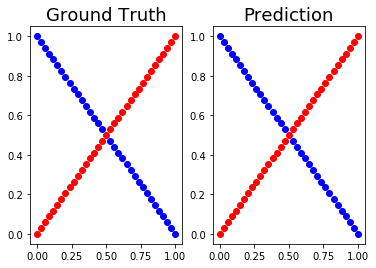

In [5]:
data, label = GenData.fetch_data('XOR', 70)

net = SimpleNet((10,10),lr=0.1,num_step=2000,print_interval=100)
net.train(data, label)

pred_result = np.zeros(label.shape)
for idx in range(len(data)):
    pred_result[idx,0]=np.round(net.forward(data[idx:idx+1,:].T))
SimpleNet.plot_result(data, label, pred_result)